# 10 Gene Conversion
# 10.1 Dependencies

In [21]:
def formatdb(ref):
    from subprocess import Popen, PIPE
    cline = 'makeblastdb -in %s -dbtype nucl' % ref
    p = Popen(cline, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    
def write_temp_window(seq,start,end, filename='temp'):
    with open(filename,'wt') as hndl:
        hndl.write('>window\n%s\n'%seq[start:end])
        
def first_and_second_match(db, query='temp', xml='temp.xml', clean=True):
    from subprocess import Popen, PIPE
    import os
    from Bio import SearchIO, SeqIO
    cline = 'blastn -query %s -db %s -outfmt 5 -out %s -evalue 0.01 -num_threads 13' % (query, db, xml)
    if len(SeqIO.read(query,'fasta')) < 50:
        cline += " -word_size 7 -penalty -3 -reward 1 -dust no"
    
    p = Popen(cline, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    q = SearchIO.read(xml,'blast-xml')
    if len(q.hits) == 0:
        return [None,None,None,None,None,None]
    elif len(q.hits) == 1:
        return [q[0][0].hit_id, q[0][0].hit_span, q[0][0].ident_num, None,None,None]
    elif len(q.hits) > 0:
        return [q[0][0].hit_id, q[0][0].hit_span, q[0][0].ident_num, 
                q[1][0].hit_id, q[1][0].hit_span, q[1][0].ident_num]
    if clean:
        os.remove(query)
        os.remove(xml)
        
def slide(query, db):
    from Bio import SeqIO
    window_matches = []
    for i in range(0,len(query)-winlen,slidelen):
        write_temp_window(str(query.seq),i,i+winlen)
        try:
            window_matches.append(first_and_second_match(db=db))
        except:
            pass
    return window_matches




# 10.2 Settings

In [ ]:
from Bio import SeqIO
from os import path
import pandas as pd


ap = 'meloidogyne_assemblies/'

miscafflen = 10000   # shortest contig allowed in query genome
winlen = 5000        # size of sliding window
slidelen = 2500      # size of overlap between windows
min_span = 2500      # minimum allowed blast alignmnet span
min_delta = 7        # minimum diffrence in identities between 1st and 2nd hits

# 10.3 Platanus VW4 as ref

In [3]:
assemblies = {
    'MfloSJF1celeraCOvsVW4platanus': ap+'MfloSJ1.scf.fasta',
    'MfloJB5velvetCOvsVW4platanus': ap+'meloidogyne.velvet.fa',
    'MincW1platanusCOvsVW4platanus': ap+'mincognita_gapClosed.fa',
    'MjavVW4platanusCOvsVW4platanus': ap+'mjavanica_gapClosed.fa',
    'MjavL57platanusCOvsVW4platanus': ap+'MjavL57_gapClosed.fa',
    'MjavLD17platanusCOvsVW4platanus': ap+'MjavLD17_gapClosed.fa',
    'MjavLD15platanusCOvsVW4platanus': ap+'MjavLD15_gapClosed.fa',
    'MjavVW5platanusCOvsVW4platanus': ap+'MjavVW5_gapClosed.fa',
    'MareHarAplatanusCOvsVW4platanus': ap+'MareHarA_gapClosed.fa',
    'MareL28platanusCOvsVW4platanus': ap+'MareL28_gapClosed.fa',
    'MareL32platanusCOvsVW4platanus': ap+'MareL32_gapClosed.fa',
    'MincA14platanusCOvsVW4platanus': ap+'MincA14_gapClosed.fa',
    'MincL27platanusCOvsVW4platanus': ap+'MincL27_gapClosed.fa',
    'MincVW6platanusCOvsVW4platanus': ap+'MincVW6_gapClosed.fa',
    'Minc557RplatanusCOvsVW4platanus': ap+'Minc557R_gapClosed.fa',
    'MincHarCplatanusCOvsVW4platanus': ap+'MincHarC_gapClosed.fa',
}

ref = assemblies['MjavVW4platanusCOvsVW4platanus']

formatdb(ref)    

for sp in assemblies:
    log_f = 'synteny/'+sp
    if path.exists(log_f):
        continue
    with open(log_f,'wt') as log:
        print sp
        scaffolds = SeqIO.index(assemblies[sp],'fasta')
        for scaffold_id in scaffolds:
            scaffold = scaffolds[scaffold_id]
            if len(scaffold) < miscafflen:
                continue
            for w in slide(scaffold,ref):
                log.write(sp + '\t' + scaffold_id + '\t%s\t%s\t%s\t%s\t%s\t%s\n'%(w[0],w[1],w[2],w[3],w[4],w[5]))

MincA14platanusGCvsVW4platanus
MincL27platanusGCvsVW4platanus
MareL28platanusGCvsVW4platanus
MincVW6platanusGCvsVW4platanus
MjavLD17platanusGCvsVW4platanus
MincHarCplatanusGCvsVW4platanus
Minc557RplatanusGCvsVW4platanus
MjavVW4platanusGCvsVW4platanus
MincW1platanusGCvsVW4platanus
MjavL57platanusGCvsVW4platanus
MjavVW5platanusGCvsVW4platanus
MfloSJF1celeraGCvsVW4platanus
MjavLD15platanusGCvsVW4platanus
MareL32platanusGCvsVW4platanus
MfloJB5velvetGCvsVW4platanus


/home/amir/anaconda2/lib/python2.7/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [4]:
for sp in assemblies:
    print sp
    with open('./synteny/%s_summary' % sp, 'wt') as hndl:
        header = ['Sample','Scaffold','Hit1','Span1','NumMatch1','Hit2','Span2','NumMatch2']
        df = pd.read_table('./synteny/%s' % sp, names = header)
        for ind in range(df.shape[0]-1):

            scaff1 = df.iloc[ind]['Scaffold']
            scaff2 = df.iloc[ind+1]['Scaffold']

            if scaff1 != scaff2:
                continue

            hit1_1 = df.iloc[ind]['Hit1']
            hit2_1 = df.iloc[ind]['Hit2']
            hit1_2 = df.iloc[ind+1]['Hit1']
            hit2_2 = df.iloc[ind+1]['Hit2']

            if not hit1_1 == hit2_2 or not hit2_1 == hit1_2:
                continue
                
            if 'None' in [hit1_1,hit2_1,hit1_2,hit2_2]:
                continue

            spans = [df.iloc[ind]['Span1']]
            spans.append(df.iloc[ind]['Span2'])
            spans.append(df.iloc[ind+1]['Span1'])
            spans.append(df.iloc[ind+1]['Span2'])    

            if 'None' in spans:
                continue

            if any([int(span) < min_span for span in spans]):
                continue

            delta1 = int(df.iloc[ind]['NumMatch1']) - int(df.iloc[ind]['NumMatch2'])
            delta2 = int(df.iloc[ind+1]['NumMatch1']) - int(df.iloc[ind+1]['NumMatch2'])

            if delta1 < min_delta or delta2 < min_delta:
                continue

            hndl.write(df.loc[ind:ind+1,].to_string() + '\n')
        
            
        
    
        

MareHarAplatanusGCvsVW4platanus
MincA14platanusGCvsVW4platanus
MincL27platanusGCvsVW4platanus
MareL28platanusGCvsVW4platanus
MincVW6platanusGCvsVW4platanus
MjavLD17platanusGCvsVW4platanus
MincHarCplatanusGCvsVW4platanus
Minc557RplatanusGCvsVW4platanus
MjavVW4platanusGCvsVW4platanus
MincW1platanusGCvsVW4platanus
MjavL57platanusGCvsVW4platanus
MjavVW5platanusGCvsVW4platanus
MfloSJF1celeraGCvsVW4platanus
MjavLD15platanusGCvsVW4platanus
MareL32platanusGCvsVW4platanus
MfloJB5velvetGCvsVW4platanus


# 10.4 Platanus W1 as ref

In [6]:
assemblies = {
    'MfloSJF1celeraCOvsW1platanus': ap+'MfloSJ1.scf.fasta',
    'MfloJB5velvetCOvsW1platanus':    ap+'meloidogyne.velvet.fa',
    'MincW1platanusCOvsW1platanus':   ap+'mincognita_gapClosed.fa',
    'MjavVW4platanusCOvsW1platanus':  ap+'mjavanica_gapClosed.fa',
    'MjavL57platanusCOvsW1platanus':  ap+'MjavL57_gapClosed.fa',
    'MjavLD17platanusCOvsW1platanus': ap+'MjavLD17_gapClosed.fa',
    'MjavLD15platanusCOvsW1platanus': ap+'MjavLD15_gapClosed.fa',
    'MjavVW5platanusCOvsW1platanus':  ap+'MjavVW5_gapClosed.fa',
    'MareHarAplatanusCOvsW1platanus': ap+'MareHarA_gapClosed.fa',
    'MareL28platanusCOvsW1platanus':  ap+'MareL28_gapClosed.fa',
    'MareL32platanusCOvsW1platanus':  ap+'MareL32_gapClosed.fa',
    'MincA14platanusCOvsW1platanus':  ap+'MincA14_gapClosed.fa',
    'MincL27platanusCOvsW1platanus':  ap+'MincL27_gapClosed.fa',
    'MincVW6platanusCOvsW1platanus':  ap+'MincVW6_gapClosed.fa',
    'Minc557RplatanusCOvsW1platanus': ap+'Minc557R_gapClosed.fa',
    'MincHarCplatanusCOvsW1platanus': ap+'MincHarC_gapClosed.fa',
}

ref = assemblies['MincW1platanusCOvsW1platanus']

formatdb(ref)    

for sp in assemblies:
    log_f = 'synteny/'+sp
    if path.exists(log_f):
        continue
    with open(log_f,'wt') as log:
        print sp
        scaffolds = SeqIO.index(assemblies[sp],'fasta')
        for scaffold_id in scaffolds:
            scaffold = scaffolds[scaffold_id]
            if len(scaffold) < miscafflen:
                continue
            for w in slide(scaffold, ref):
                log.write(sp + '\t' + scaffold_id + '\t%s\t%s\t%s\t%s\t%s\t%s\n'%(w[0],w[1],w[2],w[3],w[4],w[5]))

MareL32platanusGCvsW1platanus
MareL28platanusGCvsW1platanus
MincVW6platanusGCvsW1platanus
MjavLD15platanusGCvsW1platanus
MincW1platanusGCvsW1platanus
MfloSJF1celeraGCvsW1platanus
MjavL57platanusGCvsW1platanus
MjavVW4platanusGCvsW1platanus
MjavLD17platanusGCvsW1platanus
MjavVW5platanusGCvsW1platanus
MincA14platanusGCvsW1platanus
MareHarAplatanusGCvsW1platanus
MfloJB5velvetGCvsW1platanus
MincHarCplatanusGCvsW1platanus
MincL27platanusGCvsW1platanus
Minc557RplatanusGCvsW1platanus


In [7]:
for sp in assemblies:
    print sp
    with open('./synteny/%s_summary' % sp, 'wt') as hndl:
        header = ['Sample','Scaffold','Hit1','Span1','NumMatch1','Hit2','Span2','NumMatch2']
        df = pd.read_table('./synteny/%s' % sp, names = header)
        for ind in range(df.shape[0]-1):

            scaff1 = df.iloc[ind]['Scaffold']
            scaff2 = df.iloc[ind+1]['Scaffold']

            if scaff1 != scaff2:
                continue

            hit1_1 = df.iloc[ind]['Hit1']
            hit2_1 = df.iloc[ind]['Hit2']
            hit1_2 = df.iloc[ind+1]['Hit1']
            hit2_2 = df.iloc[ind+1]['Hit2']

            if not hit1_1 == hit2_2 or not hit2_1 == hit1_2:
                continue
                
            if 'None' in [hit1_1,hit2_1,hit1_2,hit2_2]:
                continue

            spans = [df.iloc[ind]['Span1']]
            spans.append(df.iloc[ind]['Span2'])
            spans.append(df.iloc[ind+1]['Span1'])
            spans.append(df.iloc[ind+1]['Span2'])    

            if 'None' in spans:
                continue

            if any([int(span) < min_span for span in spans]):
                continue

            delta1 = int(df.iloc[ind]['NumMatch1']) - int(df.iloc[ind]['NumMatch2'])
            delta2 = int(df.iloc[ind+1]['NumMatch1']) - int(df.iloc[ind+1]['NumMatch2'])

            if delta1 < min_delta or delta2 < min_delta:
                continue

            hndl.write(df.loc[ind:ind+1,].to_string() + '\n')

MareL32platanusGCvsW1platanus
MareL28platanusGCvsW1platanus
MincVW6platanusGCvsW1platanus
MjavLD15platanusGCvsW1platanus
MincW1platanusGCvsW1platanus
MfloSJF1celeraGCvsW1platanus
MjavL57platanusGCvsW1platanus
MjavVW4platanusGCvsW1platanus
MjavLD17platanusGCvsW1platanus
MjavVW5platanusGCvsW1platanus
MincA14platanusGCvsW1platanus
MareHarAplatanusGCvsW1platanus
MfloJB5velvetGCvsW1platanus
MincHarCplatanusGCvsW1platanus
MincL27platanusGCvsW1platanus
Minc557RplatanusGCvsW1platanus


# 10.5 Platanus HarA as ref

In [9]:
assemblies = {
    'MfloSJF1celeraCOvsHarAplatanus': ap+'MfloSJ1.scf.fasta',
    'MfloJB5velvetCOvsHarAplatanus':    ap+'meloidogyne.velvet.fa',
    'MincW1platanusCOvsHarAplatanus':   ap+'mincognita_gapClosed.fa',
    'MjavVW4platanusCOvsHarAplatanus':  ap+'mjavanica_gapClosed.fa',
    'MjavL57platanusCOvsHarAplatanus':  ap+'MjavL57_gapClosed.fa',
    'MjavLD17platanusCOvsHarAplatanus': ap+'MjavLD17_gapClosed.fa',
    'MjavLD15platanusCOvsHarAplatanus': ap+'MjavLD15_gapClosed.fa',
    'MjavVW5platanusCOvsHarAplatanus':  ap+'MjavVW5_gapClosed.fa',
    'MareHarAplatanusCOvsHarAplatanus': ap+'MareHarA_gapClosed.fa',
    'MareL28platanusCOvsHarAplatanus':  ap+'MareL28_gapClosed.fa',
    'MareL32platanusCOvsHarAplatanus':  ap+'MareL32_gapClosed.fa',
    'MincA14platanusCOvsHarAplatanus':  ap+'MincA14_gapClosed.fa',
    'MincL27platanusCOvsHarAplatanus':  ap+'MincL27_gapClosed.fa',
    'MincVW6platanusCOvsHarAplatanus':  ap+'MincVW6_gapClosed.fa',
    'Minc557RplatanusCOvsHarAplatanus': ap+'Minc557R_gapClosed.fa',
    'MincHarCplatanusCOvsHarAplatanus': ap+'MincHarC_gapClosed.fa',
}

ref = assemblies['MareHarAplatanusCOvsHarAplatanus']

formatdb(ref)    

for sp in assemblies:
    log_f = 'synteny/'+sp
    if path.exists(log_f):
        continue
    with open(log_f,'wt') as log:
        print sp
        scaffolds = SeqIO.index(assemblies[sp],'fasta')
        count_scaffs = 0
        for scaffold_id in scaffolds:
            scaffold = scaffolds[scaffold_id]
            if len(scaffold) < miscafflen:
                continue
            count_scaffs += 1
            for w in slide(scaffold, ref):
                log.write(sp + '\t' + scaffold_id + '\t%s\t%s\t%s\t%s\t%s\t%s\n'%(w[0],w[1],w[2],w[3],w[4],w[5]))
        print count_scaffs

MincW1platanusGCvsHarAplatanus
1
MjavVW4platanusGCvsHarAplatanus
1
Minc557RplatanusGCvsHarAplatanus
1
MfloSJF1celeraGCvsHarAplatanus
1
MjavVW5platanusGCvsHarAplatanus
1
MareHarAplatanusGCvsHarAplatanus
1
MareL28platanusGCvsHarAplatanus
1
MjavLD17platanusGCvsHarAplatanus
1
MincVW6platanusGCvsHarAplatanus
1
MfloJB5velvetGCvsHarAplatanus
1
MincA14platanusGCvsHarAplatanus
1
MareL32platanusGCvsHarAplatanus
1
MjavL57platanusGCvsHarAplatanus
1
MjavLD15platanusGCvsHarAplatanus
1
MincHarCplatanusGCvsHarAplatanus
1
MincL27platanusGCvsHarAplatanus
1


In [ ]:
for sp in assemblies:
    print sp
    with open('./synteny/%s_summary' % sp, 'wt') as hndl:
        header = ['Sample','Scaffold','Hit1','Span1','NumMatch1','Hit2','Span2','NumMatch2']
        df = pd.read_table('./synteny/%s' % sp, names = header)
        for ind in range(df.shape[0]-1):

            scaff1 = df.iloc[ind]['Scaffold']
            scaff2 = df.iloc[ind+1]['Scaffold']

            if scaff1 != scaff2:
                continue

            hit1_1 = df.iloc[ind]['Hit1']
            hit2_1 = df.iloc[ind]['Hit2']
            hit1_2 = df.iloc[ind+1]['Hit1']
            hit2_2 = df.iloc[ind+1]['Hit2']

            if not hit1_1 == hit2_2 or not hit2_1 == hit1_2:
                continue
                
            if 'None' in [hit1_1,hit2_1,hit1_2,hit2_2]:
                continue

            spans = [df.iloc[ind]['Span1']]
            spans.append(df.iloc[ind]['Span2'])
            spans.append(df.iloc[ind+1]['Span1'])
            spans.append(df.iloc[ind+1]['Span2'])    

            if 'None' in spans:
                continue

            if any([int(span) < min_span for span in spans]):
                continue

            delta1 = int(df.iloc[ind]['NumMatch1']) - int(df.iloc[ind]['NumMatch2'])
            delta2 = int(df.iloc[ind+1]['NumMatch1']) - int(df.iloc[ind+1]['NumMatch2'])

            if delta1 < min_delta or delta2 < min_delta:
                continue

            hndl.write(df.loc[ind:ind+1,].to_string() + '\n')

MincW1platanusGCvsHarAplatanus
MjavVW4platanusGCvsHarAplatanus
Minc557RplatanusGCvsHarAplatanus
MfloSJF1celeraGCvsHarAplatanus
MjavVW5platanusGCvsHarAplatanus
MareHarAplatanusGCvsHarAplatanus
MareL28platanusGCvsHarAplatanus
MjavLD17platanusGCvsHarAplatanus
MincVW6platanusGCvsHarAplatanus
MfloJB5velvetGCvsHarAplatanus
MincA14platanusGCvsHarAplatanus
MareL32platanusGCvsHarAplatanus
MjavL57platanusGCvsHarAplatanus
MjavLD15platanusGCvsHarAplatanus
MincHarCplatanusGCvsHarAplatanus
MincL27platanusGCvsHarAplatanus


# 10.6 Platanus Mflo as ref

In [ ]:
assemblies = {
    'MfloSJF1celeraCOvsSJF1celera':   ap+'MfloSJ1.scf.fasta',
    'MfloJB5velvetCOvsSJF1celera':    ap+'meloidogyne.velvet.fa',
    'MincW1platanusCOvsSJF1celera':   ap+'mincognita_gapClosed.fa',
    'MjavVW4platanusCOvsSJF1celera':  ap+'mjavanica_gapClosed.fa',
    'MjavL57platanusCOvsSJF1celera':  ap+'MjavL57_gapClosed.fa',
    'MjavLD17platanusCOvsSJF1celera': ap+'MjavLD17_gapClosed.fa',
    'MjavLD15platanusCOvsSJF1celera': ap+'MjavLD15_gapClosed.fa',
    'MjavVW5platanusCOvsSJF1celera':  ap+'MjavVW5_gapClosed.fa',
    'MareHarAplatanusCOvsSJF1celera': ap+'MareHarA_gapClosed.fa',
    'MareL28platanusCOvsSJF1celera':  ap+'MareL28_gapClosed.fa',
    'MareL32platanusCOvsSJF1celera':  ap+'MareL32_gapClosed.fa',
    'MincA14platanusCOvsSJF1celera':  ap+'MincA14_gapClosed.fa',
    'MincL27platanusCOvsSJF1celera':  ap+'MincL27_gapClosed.fa',
    'MincVW6platanusCOvsSJF1celera':  ap+'MincVW6_gapClosed.fa',
    'Minc557RplatanusCOvsSJF1celera': ap+'Minc557R_gapClosed.fa',
    'MincHarCplatanusCOvsSJF1celera': ap+'MincHarC_gapClosed.fa',
}

ref = assemblies['MfloSJF1celeraCOvsSJF1celera']

formatdb(ref)    

for sp in assemblies:
    log_f = 'synteny/'+sp
    if path.exists(log_f):
        continue
    with open(log_f,'wt') as log:
        print sp
        scaffolds = SeqIO.index(assemblies[sp],'fasta')
        for scaffold_id in scaffolds:
            scaffold = scaffolds[scaffold_id]
            if len(scaffold) < miscafflen:
                continue
            for w in slide(scaffold, ref):
                log.write(sp + '\t' + scaffold_id + '\t%s\t%s\t%s\t%s\t%s\t%s\n'%(w[0],w[1],w[2],w[3],w[4],w[5]))

for sp in assemblies:
    print sp
    with open('./synteny/%s_summary' % sp, 'wt') as hndl:
        header = ['Sample','Scaffold','Hit1','Span1','NumMatch1','Hit2','Span2','NumMatch2']
        df = pd.read_table('./synteny/%s' % sp, names = header)
        for ind in range(df.shape[0]-1):

            scaff1 = df.iloc[ind]['Scaffold']
            scaff2 = df.iloc[ind+1]['Scaffold']

            if scaff1 != scaff2:
                continue

            hit1_1 = df.iloc[ind]['Hit1']
            hit2_1 = df.iloc[ind]['Hit2']
            hit1_2 = df.iloc[ind+1]['Hit1']
            hit2_2 = df.iloc[ind+1]['Hit2']

            if not hit1_1 == hit2_2 or not hit2_1 == hit1_2:
                continue
                
            if 'None' in [hit1_1,hit2_1,hit1_2,hit2_2]:
                continue

            spans = [df.iloc[ind]['Span1']]
            spans.append(df.iloc[ind]['Span2'])
            spans.append(df.iloc[ind+1]['Span1'])
            spans.append(df.iloc[ind+1]['Span2'])    

            if 'None' in spans:
                continue

            if any([int(span) < min_span for span in spans]):
                continue

            delta1 = int(df.iloc[ind]['NumMatch1']) - int(df.iloc[ind]['NumMatch2'])
            delta2 = int(df.iloc[ind+1]['NumMatch1']) - int(df.iloc[ind+1]['NumMatch2'])

            if delta1 < min_delta or delta2 < min_delta:
                continue

            hndl.write(df.loc[ind:ind+1,].to_string() + '\n')

# 10.11 Summarize 

In [19]:
ap = 'meloidogyne_assemblies/'

assemblies = {
    'MfloSJF1': ap+'MfloSJ1.scf.fasta',
    'MfloJB5':  ap+'meloidogyne.velvet.fa',
    'MincW1':   ap+'mincognita_gapClosed.fa',
    'MjavVW4':  ap+'mjavanica_gapClosed.fa',
    'MjavL57':  ap+'MjavL57_gapClosed.fa',
    'MjavLD17': ap+'MjavLD17_gapClosed.fa',
    'MjavLD15': ap+'MjavLD15_gapClosed.fa',
    'MjavVW5':  ap+'MjavVW5_gapClosed.fa',
    'MareHarA': ap+'MareHarA_gapClosed.fa',
    'MareL28':  ap+'MareL28_gapClosed.fa',
    'MareL32':  ap+'MareL32_gapClosed.fa',
    'MincA14':  ap+'MincA14_gapClosed.fa',
    'MincL27':  ap+'MincL27_gapClosed.fa',
    'MincVW6':  ap+'MincVW6_gapClosed.fa',
    'Minc557R': ap+'Minc557R_gapClosed.fa',
    'MincHarC': ap+'MincHarC_gapClosed.fa',
}

In [31]:
import glob

results = {'sp':[],'vs':[],'#QueryContigs': [], 'CO loci': []}

for f in glob.glob('synteny/*platanusCOvsW1platanus'):
    
    vsW1_fp = f
    vsWW4_fp = f.replace('vsW1platanus','vsVW4platanus')
    vsHarA_fp = f.replace('vsW1platanus','vsHarAplatanus')
    vsSJF1_fp = f.replace('vsW1platanus','vsSJF1platanus')
    vsW1_sum_fp = vsW1_fp + '_summary'
    vsVW4_sum_fp = vsWW4_fp + '_summary'
    vsHarA_sum_fp = vsHarA_fp + '_summary'
    vsSJF1_sum_fp = vsSJF1_fp + '_summary'
    sp = f.split('/')[-1].split('platanus')[0]
    
    results['sp'].append(sp)
    results['vs'].append('MincW1')
    
    contigs = set()
    for l in open(vsW1_fp,'r'):
        contigs.add(l.split('\t')[1])
    results['#QueryContigs'].append(len(list(contigs)))
        
    lines = open(vsW1_sum_fp,'r').readlines()
    
    loci = []
    for i in range(0,len(lines),3):
        locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
        loci.append(locus)
    results['CO loci'].append(loci)
    
    results['sp'].append(sp)
    results['vs'].append('MjavVW4')
    
    contigs = set()
    for l in open(vsWW4_fp,'r'):
        contigs.add(l.split('\t')[1])
    results['#QueryContigs'].append(len(list(contigs)))
        
    lines = open(vsVW4_sum_fp,'r').readlines()
    
    loci = []
    for i in range(0,len(lines),3):
        locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
        loci.append(locus)
    results['CO loci'].append(loci)
    
    results['sp'].append(sp)
    results['vs'].append('MareHarA')
    
    contigs = set()
    for l in open(vsHarA_fp,'r'):
        contigs.add(l.split('\t')[1])
    results['#QueryContigs'].append(len(list(contigs)))
        
    lines = open(vsHarA_sum_fp,'r').readlines()
    
    loci = []
    for i in range(0,len(lines),3):
        locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
        loci.append(locus)
    results['CO loci'].append(loci)
    
    results['sp'].append(sp)
    results['vs'].append('MfloSJF1')
    
    contigs = set()
    for l in open(vsSJF1_fp,'r'):
        contigs.add(l.split('\t')[1])
    results['#QueryContigs'].append(len(list(contigs)))
        
    lines = open(vsSJF1_sum_fp,'r').readlines()
    
    loci = []
    for i in range(0,len(lines),3):
        locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
        loci.append(locus)
    results['CO loci'].append(loci)
        
    
    

In [32]:
vsW1_fp = 'synteny/MfloJB5velvetCOvsW1platanus'
vsWW4_fp = 'synteny/MfloJB5velvetCOvsVW4platanus'
vsHarA_fp = vsW1_fp.replace('vsW1platanus','vsHarAplatanus')
vsSJF1_fp = vsW1_fp.replace('vsW1platanus','vsSJF1platanus')
vsW1_sum_fp = vsW1_fp + '_summary'
vsVW4_sum_fp = vsWW4_fp + '_summary'
vsHarA_sum_fp = vsHarA_fp + '_summary'
vsSJF1_sum_fp = vsSJF1_fp + '_summary'
sp = 'MfloJB5'

results['sp'].append(sp)
results['vs'].append('MincW1')

contigs = set()
for l in open(vsW1_fp,'r'):
    contigs.add(l.split('\t')[1])
results['#QueryContigs'].append(len(list(contigs)))

lines = open(vsW1_sum_fp,'r').readlines()

loci = []
for i in range(0,len(lines),3):
    locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
    loci.append(locus)
results['CO loci'].append(loci)

results['sp'].append(sp)
results['vs'].append('MjavVW4')

contigs = set()
for l in open(vsWW4_fp,'r'):
    contigs.add(l.split('\t')[1])
results['#QueryContigs'].append(len(list(contigs)))

lines = open(vsVW4_sum_fp,'r').readlines()

loci = []
for i in range(0,len(lines),3):
    locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
    loci.append(locus)
results['CO loci'].append(loci)

results['sp'].append(sp)
results['vs'].append('MareHarA')

contigs = set()
for l in open(vsHarA_fp,'r'):
    contigs.add(l.split('\t')[1])
results['#QueryContigs'].append(len(list(contigs)))

lines = open(vsHarA_sum_fp,'r').readlines()

loci = []
for i in range(0,len(lines),3):
    locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
    loci.append(locus)
results['CO loci'].append(loci)


results['sp'].append(sp)
results['vs'].append('MfloSJF1')

contigs = set()
for l in open(vsSJF1_fp,'r'):
    contigs.add(l.split('\t')[1])
results['#QueryContigs'].append(len(list(contigs)))

lines = open(vsSJF1_sum_fp,'r').readlines()

loci = []
for i in range(0,len(lines),3):
    locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
    loci.append(locus)
results['CO loci'].append(loci)

In [33]:
vsW1_fp = 'synteny/MfloSJF1celeraCOvsW1platanus'
vsWW4_fp = 'synteny/MfloSJF1celeraCOvsVW4platanus'
vsHarA_fp = vsW1_fp.replace('vsW1platanus','vsHarAplatanus')
vsSJF1_fp = vsW1_fp.replace('vsW1platanus','vsSJF1celera')
vsW1_sum_fp = vsW1_fp + '_summary'
vsVW4_sum_fp = vsWW4_fp + '_summary'
vsHarA_sum_fp = vsHarA_fp + '_summary'
vsSJF1_sum_fp = vsSJF1_fp + '_summary'
sp = 'MfloSJF1'

results['sp'].append(sp)
results['vs'].append('MincW1')

contigs = set()
for l in open(vsW1_fp,'r'):
    contigs.add(l.split('\t')[1])
results['#QueryContigs'].append(len(list(contigs)))

lines = open(vsW1_sum_fp,'r').readlines()

loci = []
for i in range(0,len(lines),3):
    locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
    loci.append(locus)
results['CO loci'].append(loci)

results['sp'].append(sp)
results['vs'].append('MjavVW4')

contigs = set()
for l in open(vsWW4_fp,'r'):
    contigs.add(l.split('\t')[1])
results['#QueryContigs'].append(len(list(contigs)))

lines = open(vsVW4_sum_fp,'r').readlines()

loci = []
for i in range(0,len(lines),3):
    locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
    loci.append(locus)
results['CO loci'].append(loci)

results['sp'].append(sp)
results['vs'].append('MareHarA')

contigs = set()
for l in open(vsHarA_fp,'r'):
    contigs.add(l.split('\t')[1])
results['#QueryContigs'].append(len(list(contigs)))

lines = open(vsHarA_sum_fp,'r').readlines()

loci = []
for i in range(0,len(lines),3):
    locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
    loci.append(locus)
results['CO loci'].append(loci)


results['sp'].append(sp)
results['vs'].append('MfloSJF1')

contigs = set()
for l in open(vsSJF1_fp,'r'):
    contigs.add(l.split('\t')[1])
results['#QueryContigs'].append(len(list(contigs)))

lines = open(vsSJF1_sum_fp,'r').readlines()

loci = []
for i in range(0,len(lines),3):
    locus = set([lines[i+1].split()[3],lines[i+1].split()[6]])
    loci.append(locus)
results['CO loci'].append(loci)

In [34]:
import pandas as pd

df = pd.DataFrame.from_dict(results)

for ind,row in df.iterrows():
    df.at[ind,'Recombination per scaffold'] = len(row['CO loci'])/float(row['#QueryContigs'])

with Mflo 0.442347155965
without Mflo 0.733474808334


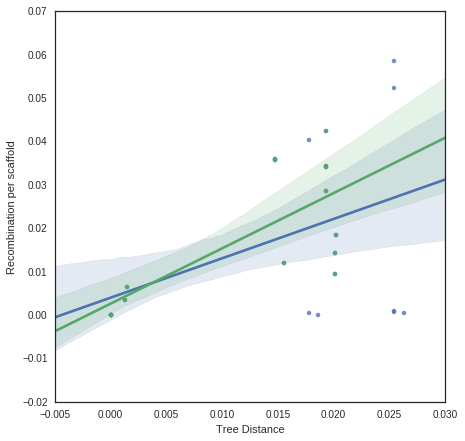

In [46]:
from ete2 import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

alndir = './orthofinder/all_inputs/Results_Jan16/I2_3X2_gt0.7_st0.001_alns_1_4'
treefile = alndir+'/RAxML_bipartitions.merged_clusters_2'

hi = df[df['#QueryContigs'] > 1600]
t = Tree(treefile)

for ind, row in hi.iterrows():
    if row['sp'] == row['vs']:
        hi.at[ind,'TreeDist'] = 0.0
    else:
        a = row['sp']+'_1'
        b = row['vs']+'_1'
        hi.at[ind,'TreeDist'] = t.get_distance(a,b)
        ab = '_'.join(sorted([a,b]))
        hi.at[ind,'Pair'] = ab
print 'with Mflo',hi['Recombination per scaffold'].corr(hi['TreeDist'])
sns.set_style("white")
        
fig, ax = plt.subplots(figsize=(7,7))
sns.regplot(x='TreeDist',y='Recombination per scaffold',data=hi,ax=ax)
hi = hi[~hi['sp'].str.contains('Mflo')]
hi = hi[~hi['vs'].str.contains('Mflo')]
print 'without Mflo',hi['Recombination per scaffold'].corr(hi['TreeDist'])
sns.regplot(x='TreeDist',y='Recombination per scaffold',data=hi,ax=ax)
ax.set_xlabel('Tree Distance')
plt.savefig('synteny/fig.png')